In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root


# Code

In [2]:
#export
from functools import reduce

from typing import Union

from scipy import sparse
import numpy as np

from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import normalize, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline

from joblib import effective_n_jobs, Parallel, delayed

from sknetwork.clustering import KMeans, Louvain, PropagationClustering

from utils import hstack, sparse_dot_product

import pandas as pd

In [3]:
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor

## Data Gneration

In [4]:
#session of variables to testing sessions
n_features = 7
cardinality_per_feature = 1000
n_classes = 5
n_reg_dims = 2


X = np.random.randint(0,cardinality_per_feature,(1000,n_features))

y_class = np.random.randint(0,n_classes, 1000)
y_reg = np.random.randn(1000,n_reg_dims)

In [5]:
#export
from sklearn.datasets import make_regression

def sigmoid(x):
    return 1/(1+np.exp(x))

def make_bimodal_assymetric_regression(
    n_samples=100000,
    bimodal_factor_weight = 2,
    n_features=15,
    n_informative=6,
    n_targets=2,
    bias=500,
    effective_rank=None,
    tail_strength=10,
    noise=150,
    shuffle=True,
    coef=False,
    random_state=None
):
    
    X,y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_targets=n_targets,
        bias=bias,
        effective_rank=effective_rank,
        tail_strength=tail_strength,
        noise=noise,
        shuffle=shuffle,
        coef=coef,
        random_state=random_state
    )


    #make one of X[1] feature mode weightening    
    bimodal_factors = (sigmoid(bimodal_factor_weight*X[:,-1]) > np.random.random(size = X.shape[0])).astype(int)
    bimodal_factors[bimodal_factors == 0] = -1
    bimodal_factors = bimodal_factors.reshape(-1,1)

    y = bimodal_factors*y
    
    return X,y

In [6]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression, make_blobs
import seaborn as sns

%matplotlib inline

X_clf, y_clf = make_classification(
    n_samples = 100_000,
    n_features = 16,
    n_informative = 8,
    n_redundant = 0,
    #bias = 10,
    #noise = 10,
    n_classes = 6,
    n_clusters_per_class = 2,
    hypercube = True,
)


blobs, labels = make_blobs(n_samples = 10_000,cluster_std = 3, n_features = 4)
#sns.scatterplot(*blobs.T, hue = labels)
#plt.show()

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
#X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2)

## leaf weights exploration

In [9]:
from lightgbm import LGBMClassifier,LGBMRegressor,LGBMRanker


In [10]:
clf = LGBMClassifier().fit(X,y)

NameError: name 'y' is not defined

In [ ]:
#sns.jointplot(data = model_df, x = "count", y = "unit_parent_gain")

In [ ]:
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
model_df["count"]/model_df["parent_count"]

In [ ]:



model_df = clf.booster_.trees_to_dataframe()
leafs = clf.predict(X, pred_leaf = True)

d_cols = ["split_gain","parent_index","node_index","count"]
parent_split_gain = pd.merge(model_df[d_cols], model_df[d_cols], left_on = "parent_index", right_on = "node_index", how = "left")

root_nodes = model_df[model_df["parent_index"].isna()][["tree_index","node_index"]].rename(columns={"node_index":"root_node"})
model_df = model_df.merge(root_nodes, how = "left", on = "tree_index")

model_df["parent_gain"] = parent_split_gain["split_gain_y"]
model_df["parent_count"] = parent_split_gain["count_y"]
model_df["parent_fraction"] = model_df["count"]/model_df["parent_count"]
model_df["cumulative_gain"] = model_df["parent_gain"]*model_df["parent_fraction"]

model_df["unit_parent_gain"] = model_df["parent_gain"]/model_df["count"]
model_df["unit_parent_gain"] = model_df["unit_parent_gain"].fillna(0)

#model_df["unit_gain"] = model_df["split_gain"]/model_df["count"]
model_df["inverse_count"] = 1/model_df["count"]
model_df["unit_weight"] = model_df["weight"]/model_df["count"]

model_df["leaf_index"] = model_df["node_index"].str.split("-").str[1].str[1:].astype(int)
model_df["leaf_index"] = np.where(model_df["right_child"].isna(), model_df["leaf_index"], None)

#path_indpr = np.hstack([[0], model_df.reset_index().groupby("tree_index")["index"].max().values])
leaf_indexes = model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "leaf_index"]).index.values
leaf_index_map = model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "leaf_index"])["node_index"]
path_pairs_df = model_df.dropna(subset = ["leaf_index"])[["root_node","node_index"]]



g = nx.Graph()
g.add_nodes_from(model_df["node_index"])
#if weighted:    
#    edge_weight_column = "parent_gain"
#    z = list(tuple(i) for i in tuple(model_df[["parent_index","node_index",edge_weight_column]].dropna().values))
#    g.add_weighted_edges_from(z)

z = list(tuple(i) for i in tuple(model_df[["parent_index","node_index"]].dropna().values))
g.add_edges_from(z)
    
    
leafs = clf.predict(X, pred_leaf = True)
leaf_encoder = OneHotEncoder().fit(leafs)

#encoded = leaf_encoder.transform(leafs)
    
#terminal_nodes = np.array(np.split(encoded.nonzero()[1], leafs.shape[0]))

In [ ]:
#check leaf nodes orderning according to output leaf nodes of estimator
(model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "leaf_index"])["count"].values == OneHotEncoder().fit_transform(leafs).sum(0).A.flatten()).mean()

In [ ]:
from tqdm import tqdm
node_weight = "cumulative_gain"
path_pairs = list(tuple(i) for i in tuple(path_pairs_df.values))
paths = np.array([np.array(nx.shortest_path(g, *i)) for i in path_pairs])

weights_df = model_df.set_index("node_index")[[node_weight, "tree_index", "node_depth"]]
weights_df["network_weight"] = np.nan
for i in (np.arange(len(path_pairs_df["node_index"]))):
    weights_df.loc[path_pairs_df.loc[path_pairs_df.index[i],"node_index"], "network_weight"] = weights_df.loc[paths[i], node_weight].sum()
    

In [ ]:
leaf_weights = weights_df.loc[leaf_index_map, "network_weight"].values.reshape(1,-1)
weights_df.groupby("tree_index").mean()[[node_weight, "network_weight"]].plot()

## Custom LGBM

# Archetypoe embedder

In [9]:
from ensemble import LGBMClassificationTransformer, ArchetypeEncoder

/Users/alan.ganem/miniconda3/envs/hml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
#X = data["data"]
#y = KBinsDiscretizer(n_bins = 10, encode = "ordinal").fit_transform(data["target"].reshape(-1,1)).flatten()

X, X_test, y, y_test = train_test_split(X_clf,y_clf, test_size = 0.90)

In [11]:
clf = LGBMClassificationTransformer().fit(X, y, leaf_weights_strategy="cumulative_unit_gain")


/Users/alan.ganem/dev/personal/heterogeneous-metric-learning/hml/ensemble.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  paths = np.array([np.array(nx.shortest_path(g, *i)) for i in path_pairs])


In [12]:
embeder = ArchetypeEncoder(clf, 10, prefit_ensemble=True, use_leaf_weights=True, fuzzy_membership=False, n_jobs = -1, graph_cluster_method = "kmeans", beta = 1)
embeder.fit(X,y)

ArchetypeEncoder(ensemble_estimator=LGBMClassificationTransformer(),
                 n_archetypes=10, n_jobs=-1, prefit_ensemble=True,
                 use_leaf_weights=True)

In [13]:
archetypes = embeder.transform(X)

In [14]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
logreg = LGBMClassifier()
logreg.fit(archetypes, y)

LGBMClassifier()

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [16]:
archetypes_test = embeder.transform(X_test, alpha = 1)

In [17]:
preds = logreg.predict_proba(archetypes_test)
preds_gbm = embeder.ensemble_estimator.predict_proba(X_test)

In [18]:
roc_auc_score(y_test, preds, multi_class="ovr"), roc_auc_score(y_test, preds_gbm, multi_class="ovr")

(0.9556159443806514, 0.9633260033747173)

# Archetype estimator

In [21]:
from meta_estimators import ArchetypeEnsembleClassifier
# X = data["data"]
# y = KBinsDiscretizer(n_bins = 10, encode = "ordinal").fit_transform(data["target"].reshape(-1,1)).flatten()

# X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2)

In [ ]:
# clf = LGBMClassifierTransformer(n_estimators=100).fit(X, y, leaf_weights_strategy="cumulative_unit_gain")
# embeder = ArchetypeEncoder(clf, 10, prefit_ensemble=True, use_leaf_weights=True, fuzzy_membership=True, n_jobs = -1, graph_cluster_method = "kmeans", beta = 1, alpha =1)
# embeder.fit(X,y)

In [22]:
from sklearn.preprocessing import QuantileTransformer

final_estim = LGBMClassifier(n_estimators=100)
estim = ArchetypeEnsembleClassifier(embeder, final_estim, prefit_embedder=True,)

In [23]:
import warnings
warnings.filterwarnings("ignore")
estim.fit(X,y)

ArchetypeEnsembleClassifier(base_embedder=ArchetypeEncoder(ensemble_estimator=LGBMClassificationTransformer(),
                                                           n_archetypes=10,
                                                           n_jobs=-1,
                                                           prefit_ensemble=True,
                                                           use_leaf_weights=True),
                            final_transformer=LGBMClassifier(),
                            prefit_embedder=True)

In [24]:
preds = estim.predict_proba(X_test)
preds_gbm = estim.base_embedder_.ensemble_estimator.predict_proba(X_test)

In [25]:
roc_auc_score(y_test, preds, multi_class="ovr"), roc_auc_score(y_test, preds_gbm, multi_class="ovr")

(0.9695188938112199, 0.9633260033747173)

# TargetBased Archetype encoder

In [293]:
from sklearn.datasets import fetch_california_housing
from ensemble import TargetArchetypeEncoder
from meta_estimators import ArchetypeEnsembleClassifier

data_house = fetch_california_housing()
X_house = data_house["data"]
y_house = KBinsDiscretizer(n_bins = 10, encode = "ordinal").fit_transform(data_house["target"].reshape(-1,1)).flatten()

X_house, X_house_test, y_house, y_house_test = train_test_split(X_house,y_house, test_size = 0.2)

In [218]:
from sklearn.cluster import KMeans


In [625]:
from sklearn.preprocessing import QuantileTransformer
from preprocessing import RobustKBinsDiscretizer
final_estim = LGBMClassifier(n_estimators=100)
#final_estim = make_pipeline(RobustKBinsDiscretizer(n_bins = 10, fuzzy_alpha=0), LogisticRegression())
#final_estim = RandomForestClassifier(n_jobs= -1)

#partition_estim = LGBMClassificationTransformer(n_estimators=100)
partition_estim = RandomForestClassifier(n_jobs= -1)
#partition_estim = make_pipeline(RobustKBinsDiscretizer(n_bins = 5, fuzzy_alpha=1), LogisticRegression())
#partition_estim = ExtraTreesClassifier(n_jobs=-1)
#partition_estim = LGBMClassificationTransformer("rf", bagging_fraction = 0.99, bagging_freq = 1, min_child_samples=2)
#partition_estim = RandomTreesEmbedding()


enc1 = TargetArchetypeEncoder(partition_estim, n_archetypes=20, prefit_estimator=False)
#enc1 = ArchetypeEncoder(partition_estim, n_archetypes=10, prefit_estimator=False)
ensemble1 = ArchetypeEnsembleClassifier(enc1, final_estim, prefit_embedder=False,)
#enc2 = TargetArchetypeEncoder(ensemble1, n_archetypes=20, prefit_estimator=False)
#ensemble1 = ArchetypeEnsembleClassifier(enc2, final_estim, prefit_embedder=False,)

In [626]:
final_estim.fit(X_house,y_house)
partition_estim.fit(X_house,y_house)

RandomForestClassifier(n_jobs=-1)

In [627]:
ensemble1.fit(X_house,y_house)

ArchetypeEnsembleClassifier(base_embedder=TargetArchetypeEncoder(estimator=RandomForestClassifier(n_jobs=-1),
                                                                 n_archetypes=20),
                            final_transformer=LGBMClassifier())

In [628]:
import warnings
warnings.filterwarnings("ignore")

In [629]:
#preds = ensemble1.predict_proba(X_test, alpha = 1, normalization_method = "l1")
preds = ensemble1.predict_proba(X_house_test)
preds_gbm = final_estim.predict_proba(X_house_test)
preds_partition = partition_estim.predict_proba(X_house_test)

In [630]:
(roc_auc_score(y_house_test, preds, multi_class="ovr") - roc_auc_score(y_house_test, preds_gbm, multi_class="ovr"))*100

0.6751151519829524

In [631]:
#preds = ensemble1.predict_proba(X_test, alpha = 1, normalization_method = "l1")
preds_train = ensemble1.predict_proba(X_house)
preds_gbm_train = final_estim.predict_proba(X_house)

In [632]:
(roc_auc_score(y_house, preds_train, multi_class="ovr") - roc_auc_score(y_house, preds_gbm_train, multi_class="ovr"))*100

1.1626955364755776

# FOrest induced UMAP

In [633]:
from ensemble import ArchetypeUMAP

In [637]:
#leaf_embs = RandomTreesEmbedding().fit_transform(X)
lgbm_transformer = LGBMClassificationTransformer(n_estimators=30)#.fit(X,y, leaf_weights_strategy = "cumulative_unit_gain")

In [638]:
#leaf_embs = clf.transform(X)
#leaf_embs_test = clf.transform(X_test)


In [640]:
fuzzy_embeder = make_pipeline(lgbm_transformer, ArchetypeUMAP(n_components = 2, n_archetypes = 50, n_neighbors = 15,fuzzy_membership=True, metric = "cosine", gamma = 1))
embeder = make_pipeline(lgbm_transformer, ArchetypeUMAP(n_components = 2, n_archetypes = 50, n_neighbors = 15, metric = "cosine", gamma = 1))

embeder.fit(X,y)
fuzzy_embeder.fit(X,y)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Pipeline(steps=[('lgbmclassificationtransformer',
                 LGBMClassificationTransformer(n_estimators=30)),
                ('archetypeumap',
                 ArchetypeUMAP(fuzzy_membership=True, n_archetypes=50))])

In [642]:
embs = embeder.transform(X)
fuzzy_embs = fuzzy_embeder.transform(X)

embs_test = embeder.transform(X_test)
fuzzy_embs_test = fuzzy_embeder.transform(X_test)

In [643]:
net_embs = embeder[1].network_embeddings_
importances = embeder[1].archetype_importances_

In [644]:
knn_preds_test = KNeighborsClassifier(50,metric = "euclidean", n_jobs = -1, weights = "distance").fit(embs,y).predict_proba(embs_test)
fuzzy_knn_preds_test = KNeighborsClassifier(50, metric = "euclidean", n_jobs = -1, weights = "distance").fit(fuzzy_embs,y).predict_proba(fuzzy_embs_test)



In [646]:
roc_auc_score(y_test,knn_preds_test, multi_class="ovr"), roc_auc_score(y_test,fuzzy_knn_preds_test, multi_class="ovr")#, roc_auc_score(y_test,lgbm.predict_proba(X_test), multi_class="ovr")

(0.7618254241632441, 0.7636188096379336)

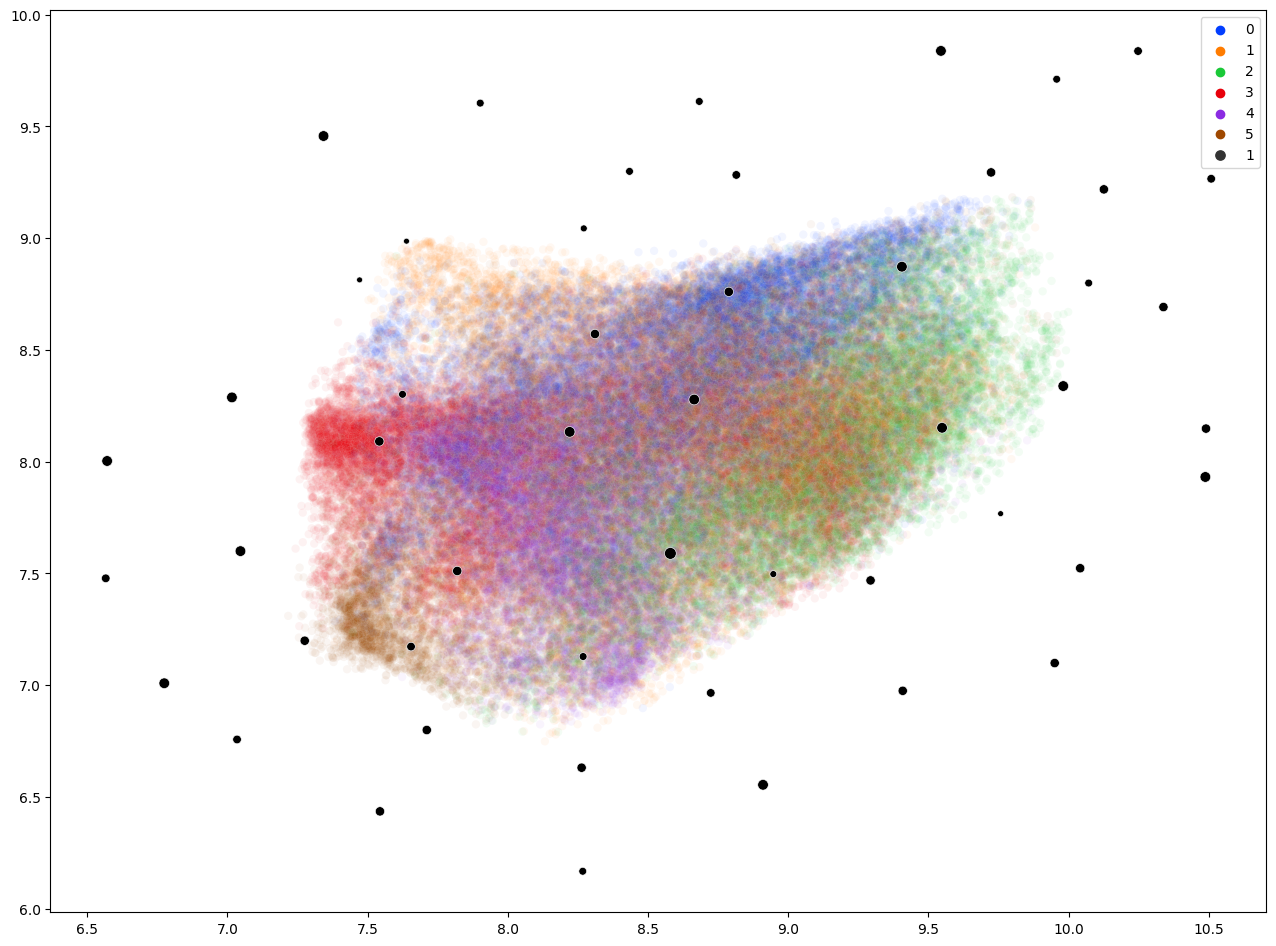

In [647]:

sns.scatterplot(
    x = embs_test.T[0],
    y = embs_test.T[1],
    alpha = 0.05,
    #hue = np.isin(y, 1 + np.array([0,1])),#np.random.choice(y, len(y)),
    hue = y_test,#np.random.choice(y, len(y)),
    #palette = "YlOrBr",
    palette = "bright",
)



sns.scatterplot(
    x = net_embs.T[0],
    y = net_embs.T[1],
    size = importances.flatten(),
    color = "black"
)
plt.subplots_adjust(-1,-1)

In [650]:
fuzzy_net_embs = fuzzy_embeder[1].network_embeddings_
fuzzy_importances = fuzzy_embeder[1].archetype_importances_

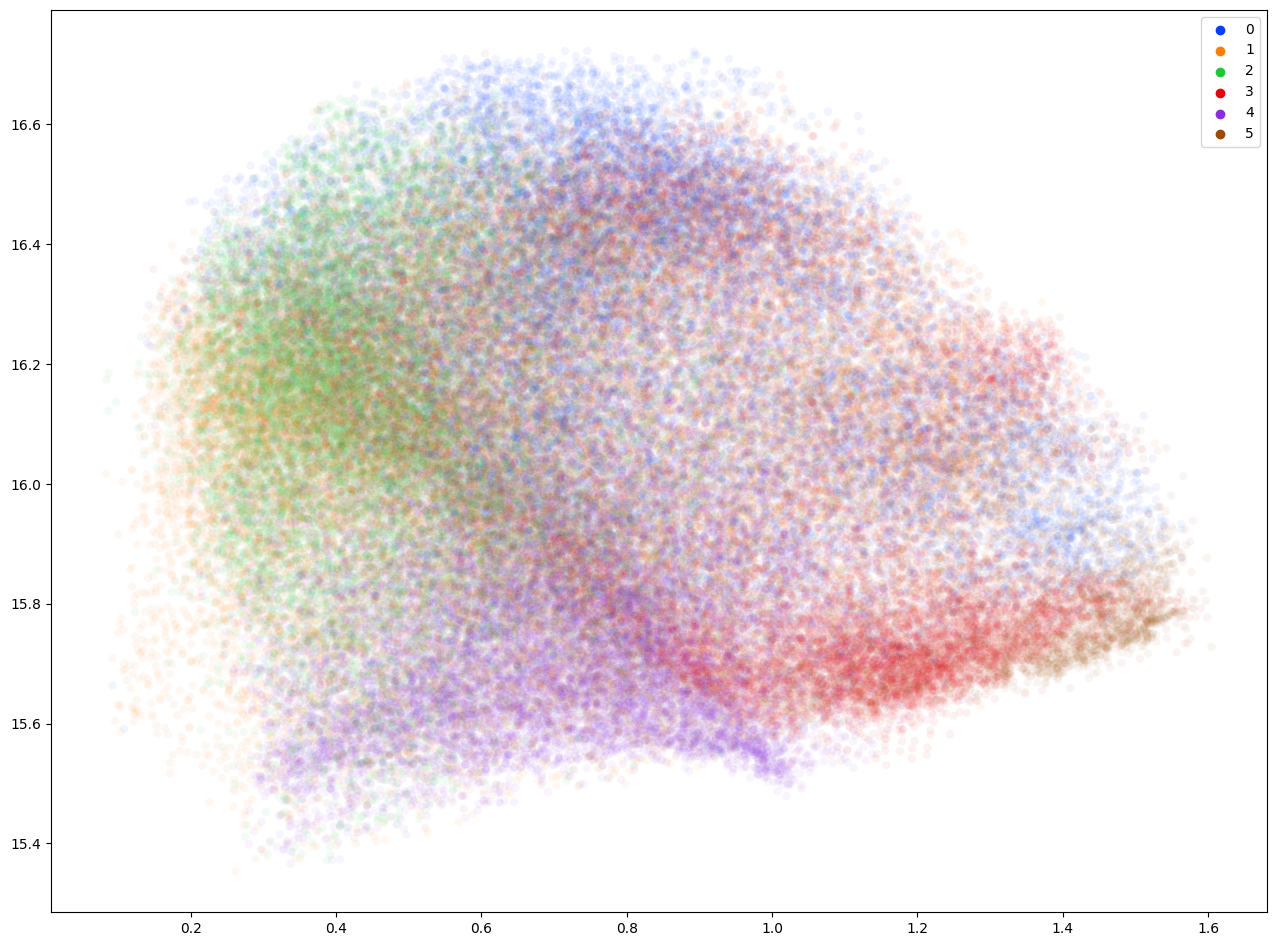

In [653]:

sns.scatterplot(
    x = fuzzy_embs_test.T[0],
    y = fuzzy_embs_test.T[1],
    alpha = 0.05,
    #hue = np.isin(y_test, 1 + np.array([0,1])),#np.random.choice(y, len(y)),
    hue = y_test,#np.random.choice(y, len(y)),
    #palette = "YlOrBr",
    palette = "bright",
)

# sns.scatterplot(
#     x = fuzzy_net_embs.T[0],
#     y = fuzzy_net_embs.T[1],
#     size = fuzzy_importances.flatten(),
#     color = "black"
# )
plt.subplots_adjust(-1,-1)

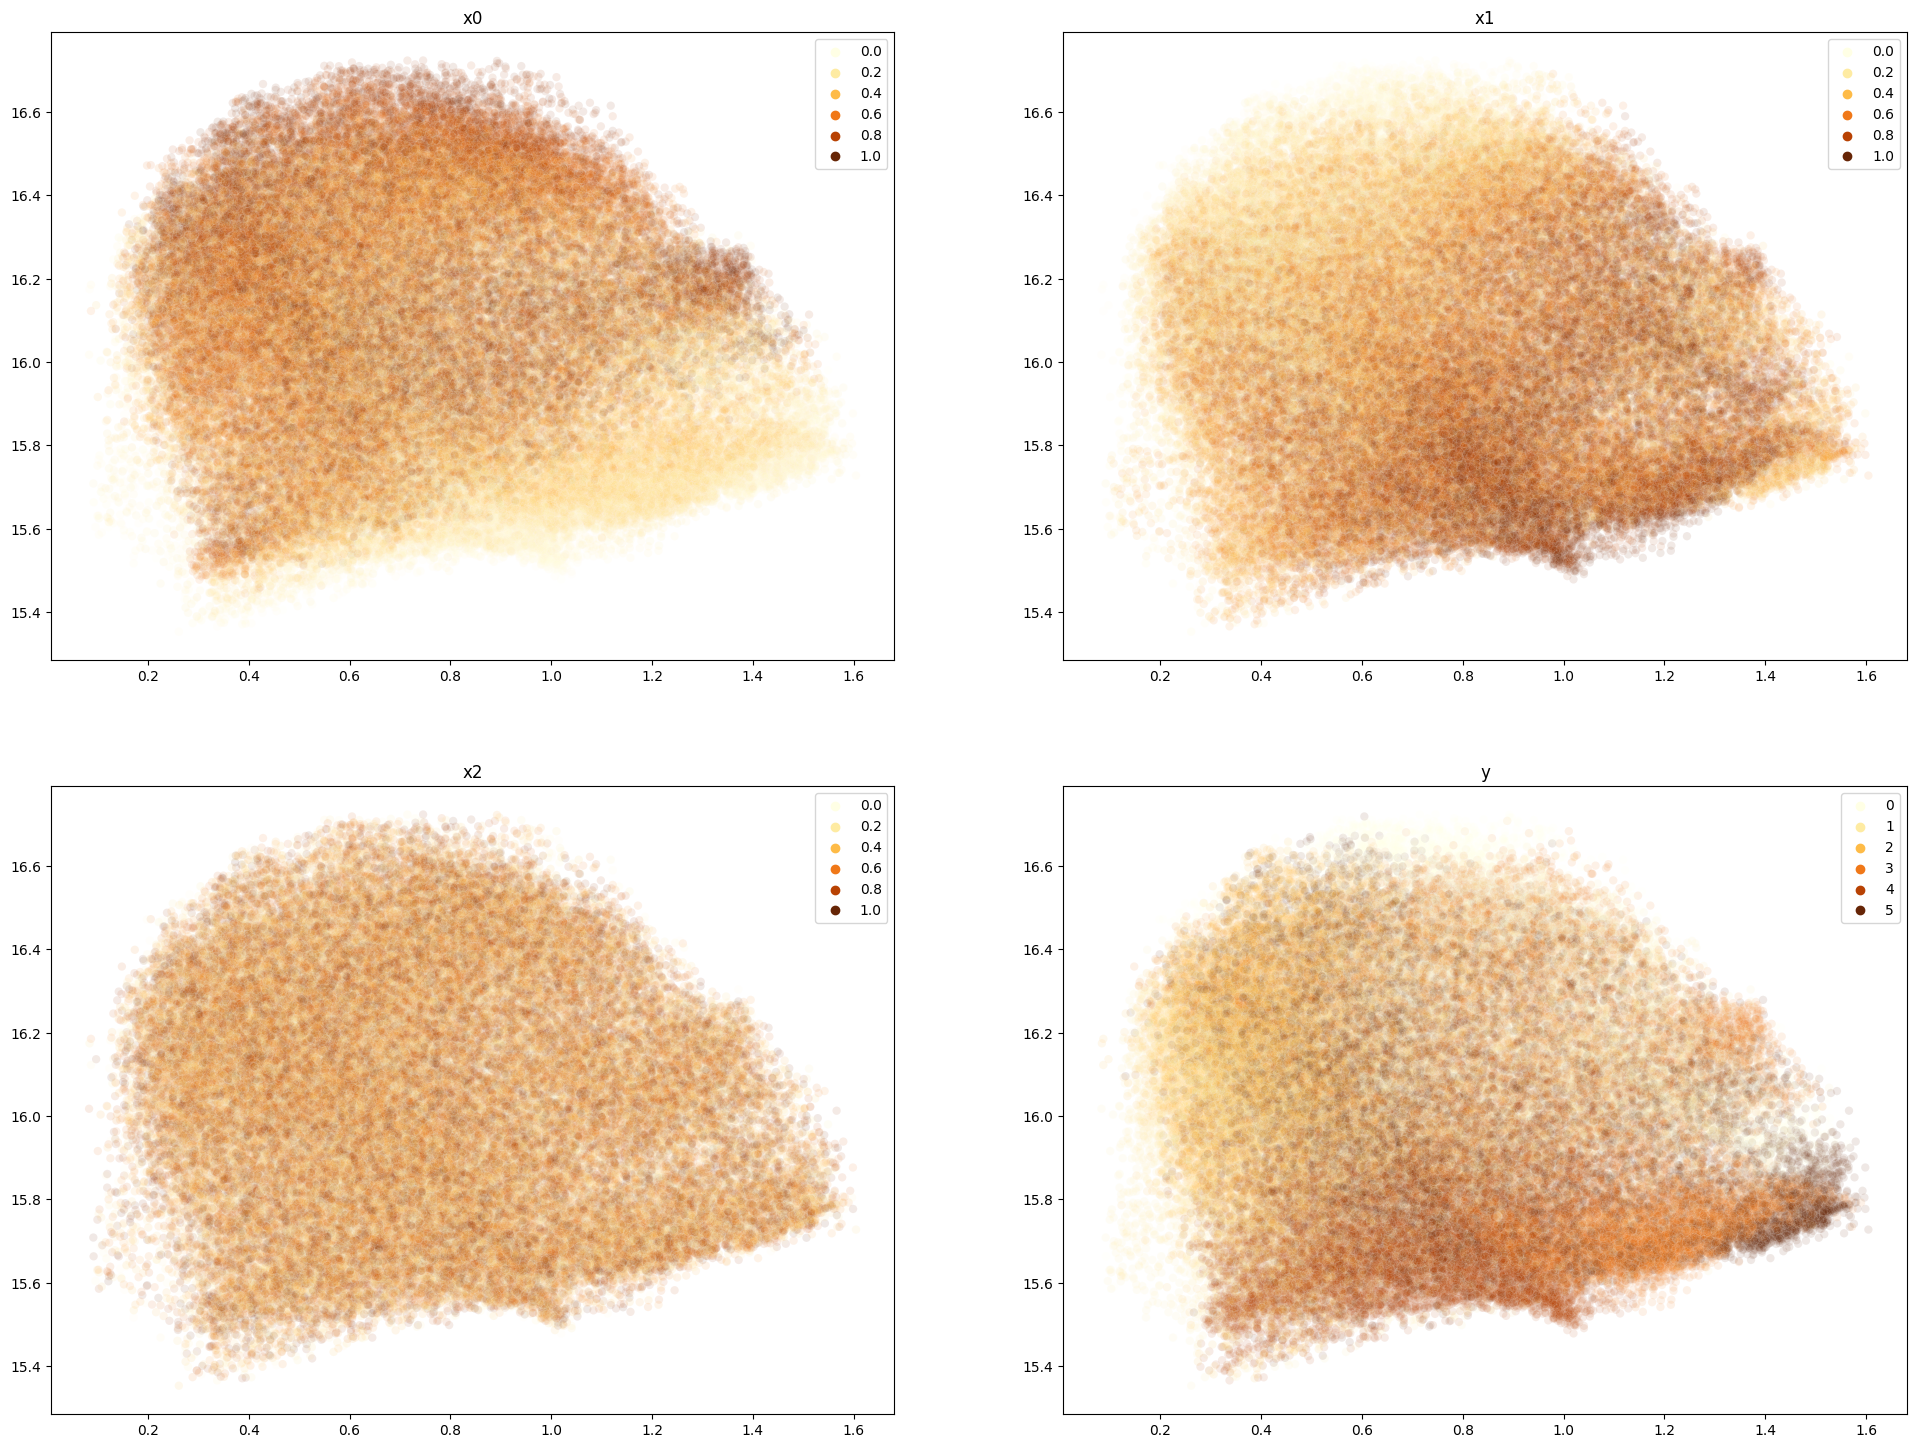

In [652]:
from sklearn.preprocessing import quantile_transform
fig,axs = plt.subplots(2,2)

sns.scatterplot(
    x = fuzzy_embs_test.T[0],
    y = fuzzy_embs_test.T[1],
    alpha = 0.1,
    hue = quantile_transform(X_test[:,0:1]).flatten(),
    palette = "YlOrBr",
    ax = axs[0,0],    
)
sns.scatterplot(
    x = fuzzy_embs_test.T[0],
    y = fuzzy_embs_test.T[1],
    alpha = 0.1,
    hue = quantile_transform(X_test[:,1:2]).flatten(),
    palette = "YlOrBr",
    ax = axs[0,1],
)

sns.scatterplot(
    x = fuzzy_embs_test.T[0],
    y = fuzzy_embs_test.T[1],
    alpha = 0.1,
    hue = quantile_transform(X_test[:,2:3]).flatten(),
    palette = "YlOrBr",
    ax = axs[1,0],
)

sns.scatterplot(
    x = fuzzy_embs_test.T[0],
    y = fuzzy_embs_test.T[1],
    alpha = 0.1,
    hue = y_test,
    palette = "YlOrBr",
    ax = axs[1,1],
)


axs[0,0].set_title ("x0")
axs[0,1].set_title ("x1")
axs[1,0].set_title ("x2")
axs[1,1].set_title ("y")
plt.subplots_adjust(-2,-2)
#sns.scatterplot(*embs.T)